# Visualise the tracked MHWs

In [1]:
import xarray as xr
import numpy as np
import dask

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

## Local Cluster
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)

## Import Processed Data

In [4]:
blobs = xr.open_dataset(scratch_dir / '02_tracked_dask.nc', chunks={'time': 50, 'lat': -1, 'lon': -1}).labels
blobs

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'labels' (time: 13878, lat: 721, lon: 1440)> Size: 115GB
dask.array<open_dataset-labels, shape=(13878, 721, 1440), dtype=float64, chunksize=(50, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    decimal_year  (time) float64 111kB dask.array<chunksize=(50,), meta=np.ndarray>
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time          (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12...
Attributes:
    size quantile threshold:    0.5
    percent area reject:        0.09162668964897586
    final objects tracked:      16524
    percent area accept:        0.9083733103510242
    radius:                     8
    inital objects identified:  347394
    min area:                   744.0

In [5]:
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_dask.zarr'), chunks={'time': 50, 'lat': -1, 'lon': -1})
ds

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 234GB
Dimensions:           (dayofyear: 366, time: 13879, lat: 721, lon: 1440)
Coordinates:
  * dayofyear         (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
    decimal_year      (time) float64 111kB dask.array<chunksize=(50,), meta=np.ndarray>
  * lat               (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon               (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time              (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 203...
Data variables:
    features_notrend  (time, lat, lon) float64 115GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
    mask              (lat, lon) bool 1MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ssta_notrend      (time, lat, lon) float64 115GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
    stdev             (dayofyear, lat, lon) float64 3GB dask.array<chunksize=(366, 721, 1440), meta=np.ndarray>
Attributes:
    climatology:  entire period
    description:  ICON erc1011 preprocessed for Ocetrac-dask
    threshold:    95th percentile

## Plot some Blobs

In [6]:
blob_subset = blobs.sel(time=slice('2020-01-01', '2021-01-01')).resample(time='MS').first()
maxl = blob_subset.max().compute().item()
minl = blob_subset.min().compute().item()

In [7]:
cm = ListedColormap(np.random.random(size=(int(maxl-minl), 3)).tolist())

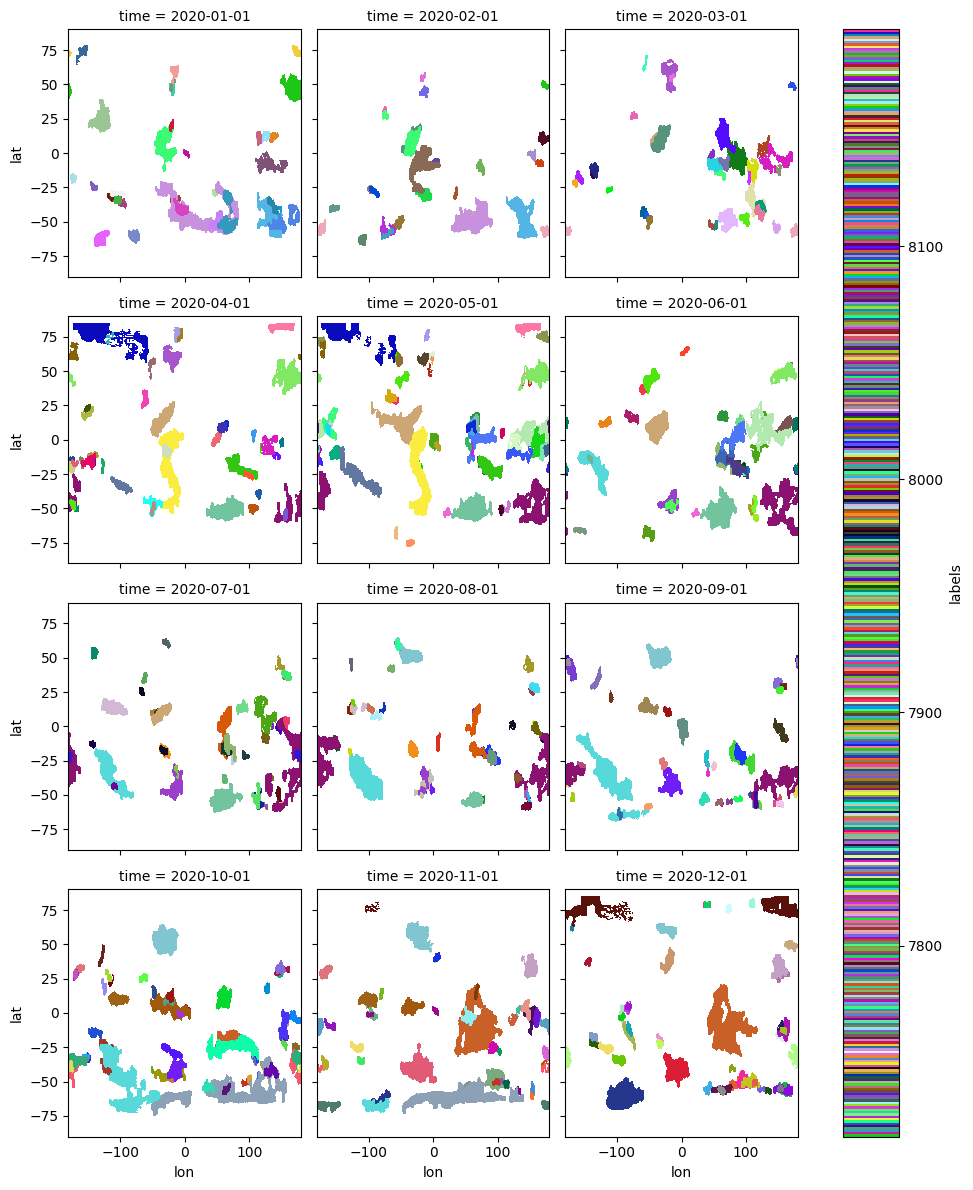

In [10]:
blobs_first_day = blobs.sel(time=slice('2020-01-01', '2020-12-31')).resample(time='MS').first()
blobs_first_day.plot(col='time', col_wrap=3, cmap=cm)

## Global MHW Frequency

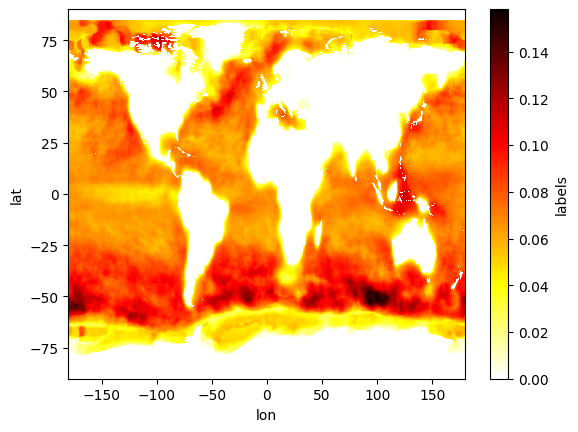

In [11]:
mhw_frequency = xr.where((blobs == 0) | np.isnan(blobs), 0.0, 1.0).mean('time')
mhw_frequency.plot(cmap='hot_r')

## Consider one MHW

In [ ]:
event = 100

In [ ]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [ ]:
id = 35
event = blobs.where(blobs==id, drop=True)
event.shape

In [ ]:
# Create intensity image for the Indian Ocean marine heatwave
event_intensity = ds.anom.isel(zlev=0).where((ds.time==event.time) & 
                                             (ds.lat==event.lat) & 
                                             (ds.lon==event.lon), 
                                             drop=True).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.fillna(0)

plt.rc('font', size=12); plt.figure(figsize=(15,6));
for i in enumerate(range(1,len(event.time))):
    ax = plt.subplot(2,3,i[1],projection=ccrs.PlateCarree())
    event_intensity.isel(time=i[0], intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2,  
                                                      cmap='RdBu_r', extend='both', add_colorbar=True, add_labels=False)
    plt.title(event.isel(time=i[0]).time.values.astype('datetime64[D]'))
    ax.coastlines(resolution='110m', color='black', linewidth=1) 
    ax.add_feature(cfeature.LAND, facecolor='w');
    events_contour.isel(time=i[0]).plot.contour(levels=[34,35], transform=ccrs.PlateCarree(), colors='b', linewidths=4, add_colorbar=False, add_labels=False)